# Time Series Forecasting for Predicting Store Sales

by : Septia Wulandari Suarka

dataset : https://www.kaggle.com/datasets/rohitsahoo/sales-forecasting?resource=download

## Loading the Dataset & Checking Variables

In [2]:
#Loading the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import itertools
from datetime import datetime

from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from sklearn.metrics import mean_squared_error
from prophet import Prophet
pd.options.display.float_format = '{:.2f}'.format

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

### Read Data

In [3]:
#Read data
data = pd.read_csv('train.csv')
data = data.drop(['Row ID','Ship Date','Postal Code'], axis = 1)
data.head()

Order ID  Order Date       Ship Mode Customer ID    Customer Name  \
0  CA-2017-152156  08/11/2017    Second Class    CG-12520      Claire Gute   
1  CA-2017-152156  08/11/2017    Second Class    CG-12520      Claire Gute   
2  CA-2017-138688  12/06/2017    Second Class    DV-13045  Darrin Van Huff   
3  US-2016-108966  11/10/2016  Standard Class    SO-20335   Sean O'Donnell   
4  US-2016-108966  11/10/2016  Standard Class    SO-20335   Sean O'Donnell   

     Segment        Country             City       State Region  \
0   Consumer  United States        Henderson    Kentucky  South   
1   Consumer  United States        Henderson    Kentucky  South   
2  Corporate  United States      Los Angeles  California   West   
3   Consumer  United States  Fort Lauderdale     Florida  South   
4   Consumer  United States  Fort Lauderdale     Florida  South   

        Product ID         Category Sub-Category  \
0  FUR-BO-10001798        Furniture    Bookcases   
1  FUR-CH-10000454        Furniture       Chairs   
2  OFF-LA-10000240  Office Supplies       Labels   
3  FUR-TA-10000577        Furniture       Tables   
4  OFF-ST-10000760  Office Supplies      Storage   

                                        Product Name  Sales  
0                  Bush Somerset Collection Bookcase 261.96  
1  Hon Deluxe Fabric Upholstered Stacking Chairs,... 731.94  
2  Self-Adhesive Address Labels for Typewriters b...  14.62  
3      Bretford CR4500 Series Slim Rectangular Table 957.58  
4                     Eldon Fold 'N Roll Cart System  22.37

In [4]:
data.shape

(9800, 15)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order ID       9800 non-null   object 
 1   Order Date     9800 non-null   object 
 2   Ship Mode      9800 non-null   object 
 3   Customer ID    9800 non-null   object 
 4   Customer Name  9800 non-null   object 
 5   Segment        9800 non-null   object 
 6   Country        9800 non-null   object 
 7   City           9800 non-null   object 
 8   State          9800 non-null   object 
 9   Region         9800 non-null   object 
 10  Product ID     9800 non-null   object 
 11  Category       9800 non-null   object 
 12  Sub-Category   9800 non-null   object 
 13  Product Name   9800 non-null   object 
 14  Sales          9800 non-null   float64
dtypes: float64(1), object(14)
memory usage: 1.1+ MB


No missing values on dataset

### Datetime Conversion

In [6]:
# Casting data type
data['Order Date'] = pd.to_datetime(data['Order Date'], format='%d/%m/%Y')

### Check Duplicate

In [7]:
# Check Duplicate
data[data.duplicated(keep=False)].head()

Order ID Order Date       Ship Mode Customer ID   Customer Name  \
3405  US-2015-150119 2015-04-23  Standard Class    LB-16795  Laurel Beltran   
3406  US-2015-150119 2015-04-23  Standard Class    LB-16795  Laurel Beltran   

          Segment        Country      City State Region       Product ID  \
3405  Home Office  United States  Columbus  Ohio   East  FUR-CH-10002965   
3406  Home Office  United States  Columbus  Ohio   East  FUR-CH-10002965   

       Category Sub-Category  \
3405  Furniture       Chairs   
3406  Furniture       Chairs   

                                           Product Name  Sales  
3405  Global Leather Highback Executive Chair with P... 281.37  
3406  Global Leather Highback Executive Chair with P... 281.37

In [9]:
# Drop duplicate
data.drop_duplicates(keep='first', inplace=True, ignore_index=True)

data.shape

(9799, 15)

In [8]:
data.describe().T

count                           mean                  min  \
Order Date    9800  2017-05-01 05:13:51.673469440  2015-01-03 00:00:00   
Sales      9800.00                         230.77                 0.44   

                            25%                  50%                  75%  \
Order Date  2016-05-24 00:00:00  2017-06-26 00:00:00  2018-05-15 00:00:00   
Sales                     17.25                54.49               210.61   

                            max    std  
Order Date  2018-12-30 00:00:00    NaN  
Sales                  22638.48 626.65

In [10]:
df = data[['Order Date', 'Sales']].copy(deep = True)
df.set_index('Order Date', inplace = True)
df = df.resample('W').sum()
df.head()

Sales
Order Date        
2015-01-04  304.51
2015-01-11 4619.11
2015-01-18 4130.53
2015-01-25 3092.54
2015-02-01 2527.91

## Exploratory Data Analysis

In [11]:
color1 = ['#296C92', '#3EB489']
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

plt.subplot(1,2,1)
sns.distplot(data['Sales']);
plt.title('Distribution : Sales')

plt.subplot(1,2,2);
sns.distplot(df['Sales'])
plt.title('Distribution : Sales')

fig,ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20,5))
plt.subplot(1,1,1)
sns.lineplot(x = df.index, y = 'Sales', data = df, palette = color1);
plt.title('Sales vs Date')

plt.show()
fig.tight_layout(pad=2)

C:\Users\pradi\AppData\Local\Temp\ipykernel_17708\1424280003.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Sales']);
C:\Users\pradi\AppData\Local\Temp\ipykernel_17708\1424280003.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Sales'])
C:\Users\pradi\AppData\Local\Temp\ipykern

- Data penjualan berdistribusi positif skewness bernilai positif yang sangat kuat.
- Data penjualan yang telah di-resampled memiliki persebaran distribusi yang lebih baik namun tetap berdistribusi positif skewness.
- Dari tren penjualan dapat dilihat penjualan akan mengalami penurunan setelah bulan Januari dan mengalami peningkatan setelah bulan Juli.

In [12]:
#Date from order
df1 = data.copy(deep = True)
df1['month'] = df1['Order Date'].dt.month
df1['year'] = df1['Order Date'].dt.year
df1['week_year'] = df1['Order Date'].dt.isocalendar().week
df1['dayofweek'] = df1['Order Date'].dt.dayofweek+1
df1.head()

Order ID Order Date       Ship Mode Customer ID    Customer Name  \
0  CA-2017-152156 2017-11-08    Second Class    CG-12520      Claire Gute   
1  CA-2017-152156 2017-11-08    Second Class    CG-12520      Claire Gute   
2  CA-2017-138688 2017-06-12    Second Class    DV-13045  Darrin Van Huff   
3  US-2016-108966 2016-10-11  Standard Class    SO-20335   Sean O'Donnell   
4  US-2016-108966 2016-10-11  Standard Class    SO-20335   Sean O'Donnell   

     Segment        Country             City       State Region  \
0   Consumer  United States        Henderson    Kentucky  South   
1   Consumer  United States        Henderson    Kentucky  South   
2  Corporate  United States      Los Angeles  California   West   
3   Consumer  United States  Fort Lauderdale     Florida  South   
4   Consumer  United States  Fort Lauderdale     Florida  South   

        Product ID         Category Sub-Category  \
0  FUR-BO-10001798        Furniture    Bookcases   
1  FUR-CH-10000454        Furniture       Chairs   
2  OFF-LA-10000240  Office Supplies       Labels   
3  FUR-TA-10000577        Furniture       Tables   
4  OFF-ST-10000760  Office Supplies      Storage   

                                        Product Name  Sales  month  year  \
0                  Bush Somerset Collection Bookcase 261.96     11  2017   
1  Hon Deluxe Fabric Upholstered Stacking Chairs,... 731.94     11  2017   
2  Self-Adhesive Address Labels for Typewriters b...  14.62      6  2017   
3      Bretford CR4500 Series Slim Rectangular Table 957.58     10  2016   
4                     Eldon Fold 'N Roll Cart System  22.37     10  2016   

   week_year  dayofweek  
0         45          3  
1         45          3  
2         24          1  
3         41          2  
4         41          2

In [13]:
px.box(df1, x='year', y='Sales', color = 'month', title = 'Sales')

Berdasarkan total sales tiap bulannya, tidak terlihat tren peningkatan penjualan tiap-tiap bulan dari tahun 2015-2018. Di tahun 2015, terdapat total sales tertinggi pada bulan 3 sebesar 22k.

In [14]:
a = (df1.groupby(['year', 'dayofweek'])
     .agg({'Sub-Category' : 'count', 'Sales' : 'sum'})
     .reset_index()
     .rename(columns={'Sub-Category' : 'Transactions', 'Sales' : 'Total Sales'}))

px.line(a, x='dayofweek', y='Transactions', color='year', title='Transactions')

Dilihat dari tren penjualan tiap minggu, penjualan akan mengalami peningkatan di minggu kedua namun turun di minggu ke-4/5 dan mengalami peningkatan di minggu ke-6.

In [15]:
df = df1.set_index('Order Date').groupby('Sub-Category').resample("D").Sales.sum().reset_index()

px.line(df, x = 'Order Date', y = 'Sales', color = 'Sub-Category', title = 'Daily total sales')

Dilihat dari penjualan harian, penjualan tertinggi ada pada sub-kategori machines dan copiers.

In [16]:
df = df1.groupby('Sub-Category').Sales.mean().sort_values(ascending = False).reset_index()

px.bar(df, y = 'Sub-Category', x = 'Sales', color = 'Sub-Category',
      title = 'Which prouct preferred more?')

Sesuai dengan visualisasi penjualan harian tertinggi, produk yang paling banyak terjual adalah sub-kategori copiers dan machine.

In [17]:
px.line(df1.groupby(['State', 'year']).Sales.mean().reset_index(),
        x = 'year', y = 'Sales', color = 'State')

Penjualan tertinggi di tahun 2015 ada pada Kota Minnesota dan Iowa. Di tahun 2016 Kota Vermont memiliki penjualan yang sangat tinggi namun terus mengalami penurunan yang sangat signifikan hingga di tahun 2018. di tahun 2017, Kota Nevada dan Rhode Island menjadi kota dengan penjualan tertinggi. Tahun 2018, Kota Montana dan Delaware menjadi kota dengan penjualan tertinggi.

## Time Series Analysis

- Melakukan resample dari "Order Date" column menjadi format data mingguan.
- Fungsi agregat yang digunakan adalah "sum()". Dengan ini jika ada titik data yang berada di antara minggu tersebut, nilai titik data tersebut akan dijumlahkan dan akan ditetapkan ke hari pertama dalam minggu tersebut.
- Dalam analisa ini, jenis time series analisis yang digunakan adalah univariate time series analysis problem dimana kita akan melakukan forecast variabel dependent yaitu **Sales**. Sehingga variabel **Order Date** akan diset menjadi index.

In [21]:
df = data[['Order Date', 'Sales']].copy(deep = True)
df.set_index('Order Date', inplace = True)
df = df.resample('W').sum()
df.head()

Sales
Order Date        
2015-01-04  304.51
2015-01-11 4619.11
2015-01-18 4130.53
2015-01-25 3092.54
2015-02-01 2527.91

### Split the Data 

Melakukan split data, dengan jumlah data test sebanyak 30 dari total dataset.

In [22]:
size = int(len(df) - 30)
train, test = df[:size], df[size:]

# infer frequency for modeling
sales_train = train.asfreq(pd.infer_freq(train.index))
sales_test = test.asfreq(pd.infer_freq(test.index))
df = df.asfreq(pd.infer_freq(df.index))

In [23]:
sales_train.shape

(179, 1)

In [24]:
sales_test.shape

(30, 1)

### Supportive Functions for TIme Series Analysis

In [25]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window = 12).mean()
    MSTD = timeseries.rolling(window = 12).std()
    
    #Plot rolling statistics
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

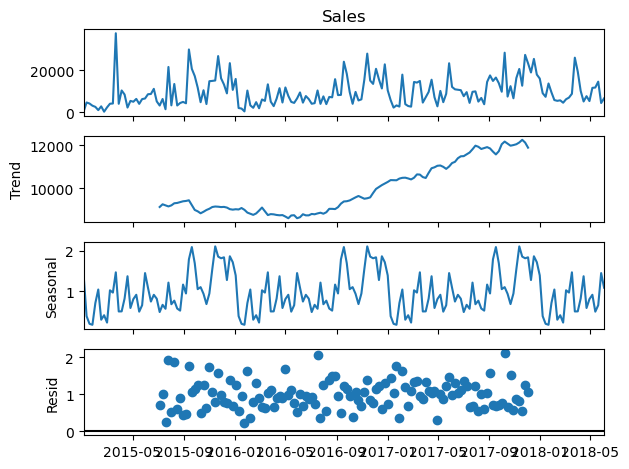

In [26]:
dec = sm.tsa.seasonal_decompose(sales_train['Sales'], model = 'multiplicative').plot()
plt.show()

- Data memiliki tren yang non-linear
- Pola musiman yang jelas terlihat pada data.

**Stationarity**

Stationarity adalah konsep time series di mana parameter statistik seperti mean, varians, dll semuanya konstan sepanjang waktu. Untuk menilai stationarity, kita akan menggunakan **Augmented Dickey Fuller Test** :

- **Null Hypothesis** : Asumsi bahwa data time series non-stationarity
- **Alternate Hypothesis** : Jika null hipotesis ditolak, maka data time series bersifat stationer.
- Output dari Augmented Dickey Fuller Test :
    - Test Statistic
    - p-value
    - #Lags Used
    - Number of Observations Used
    - Critical Value (1%)
    - Critical Value (5%)
    - Critical Value (10%)

- Untuk menolak null hipotesis, parameter yang digunakan :
    - **Critical Value (5%) > Test Statistic**
    - **p-value < 0.05**

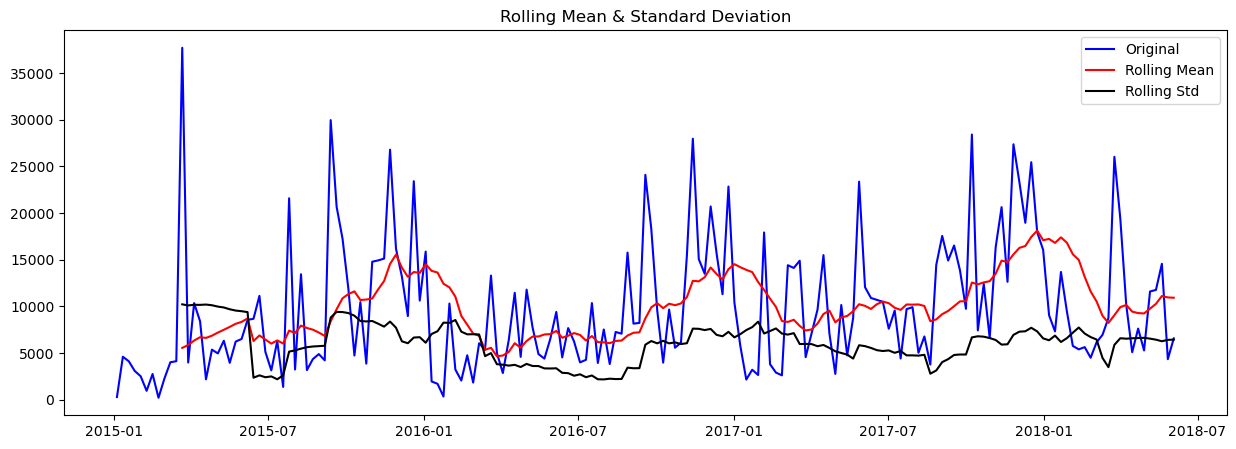

Results of Dickey-Fuller Test:
Test Statistic                 -6.37
p-value                         0.00
#Lags Used                      1.00
Number of Observations Used   177.00
Critical Value (1%)            -3.47
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [27]:
test_stationarity(sales_train['Sales'])

Untuk **Sales** time series data:
- Critival Value (5%) : -2.88 > Test Statistic : -6.37
- p-value : 0.00 > 0.05

Berdasarkan hail dari Dickey-Fuller Test, null hipotesis ditolak, sehingga dapat dikatakan Sales time series bersifat stasioner.

## Modeling: ARIMA

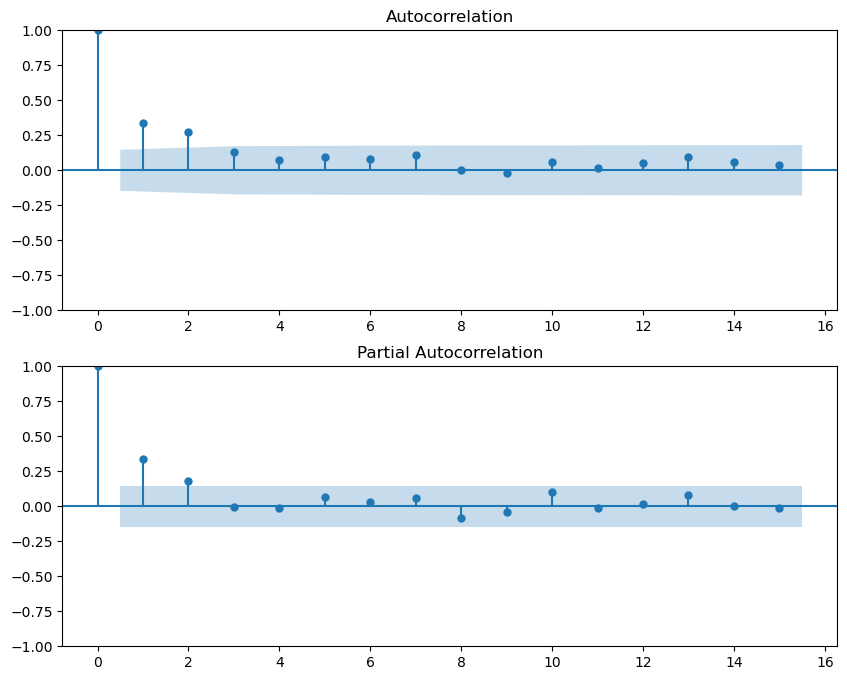

In [28]:
fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sales_train["Sales"], lags=15, ax=ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sales_train["Sales"], lags=15, ax=ax2)

Berdasarkan plot diatas, nilai pdq pada model ARIMA yang digunakan:
- p : 1
- d : 0
- q : 2

In [29]:
# Fit model
arima_model = ARIMA(sales_train, order=(1,0,2)).fit()

print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  179
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -1821.163
Date:                Thu, 04 Jan 2024   AIC                           3652.326
Time:                        11:20:12   BIC                           3668.263
Sample:                    01-04-2015   HQIC                          3658.788
                         - 06-03-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9745.8433    845.810     11.522      0.000    8088.085    1.14e+04
ar.L1          0.4506      0.255      1.764      0.078      -0.050       0.951
ma.L1         -0.1698      0.262     -0.648      0.5

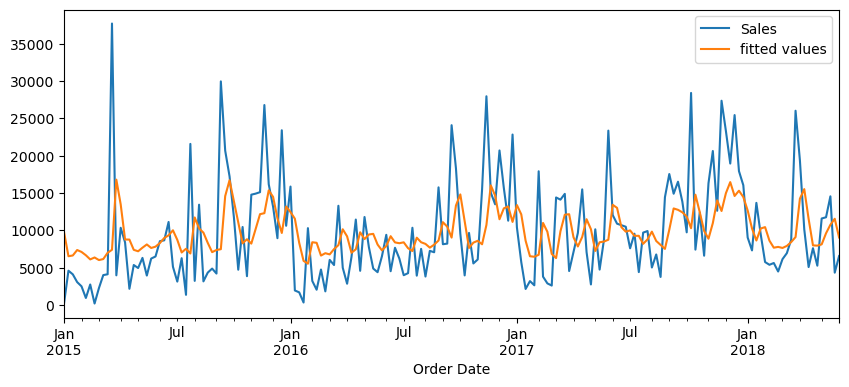

In [30]:
sales_train.plot(figsize = (10,4), legend = True)
arima_model.fittedvalues.plot(figsize = (10,4), label = "fitted values", legend = True)
plt.show()

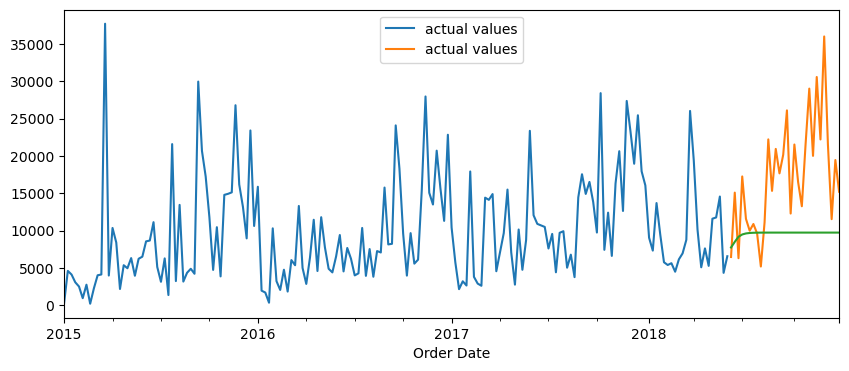

In [31]:
sales_train['Sales'].plot(figsize = (10,4), legend = True, label = "actual values")
sales_test['Sales'].plot(figsize = (10,4), legend = True, label = "actual values")
arima_model.forecast(steps = 30).plot()
plt.show()

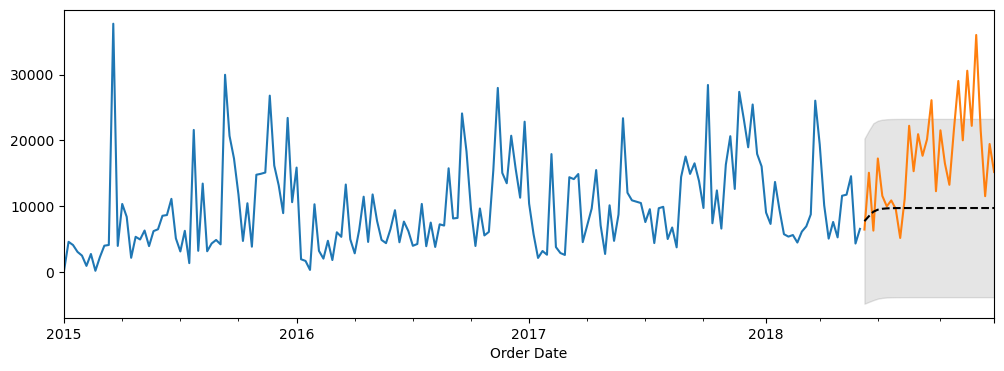

In [32]:
# Construct the forecast and the prediction interval
fig, ax = plt.subplots(figsize = (12,4))

#Plot the data
sales_train['Sales'].plot(ax =ax)
sales_test['Sales'].plot(ax = ax)

#Plot the forecast
fcast = arima_model.get_forecast(steps = 30).summary_frame()
fcast['mean'].plot(ax = ax, style='k--')

#Plot the conf interval
ax.fill_between(fcast.index,
               fcast['mean_ci_lower'],
               fcast['mean_ci_upper'], color='k', alpha=0.1)

plt.show()

In [33]:
rmse_train = np.sqrt(mse(sales_train['Sales'], arima_model.fittedvalues))
rmse_train

6345.2601700334135

In [34]:
arima_rmse_test = np.sqrt(mse(sales_test['Sales'], arima_model.forecast(steps = 30)))
arima_rmse_test

10419.702952210115

## Modeling: SARIMA

- Format data yg digunakan ada data time series mingguan dan periode seasonal 1 tahun. Sehingga melakukan differencing dengan nilai 52.

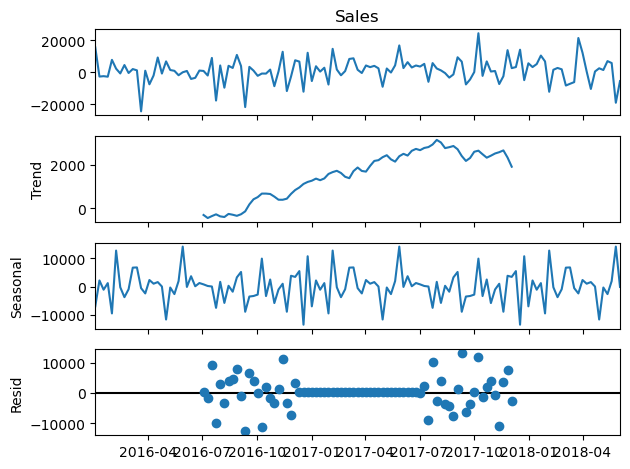

In [35]:
dec = sm.tsa.seasonal_decompose(sales_train['Sales'].diff(52).dropna()).plot()
plt.show()

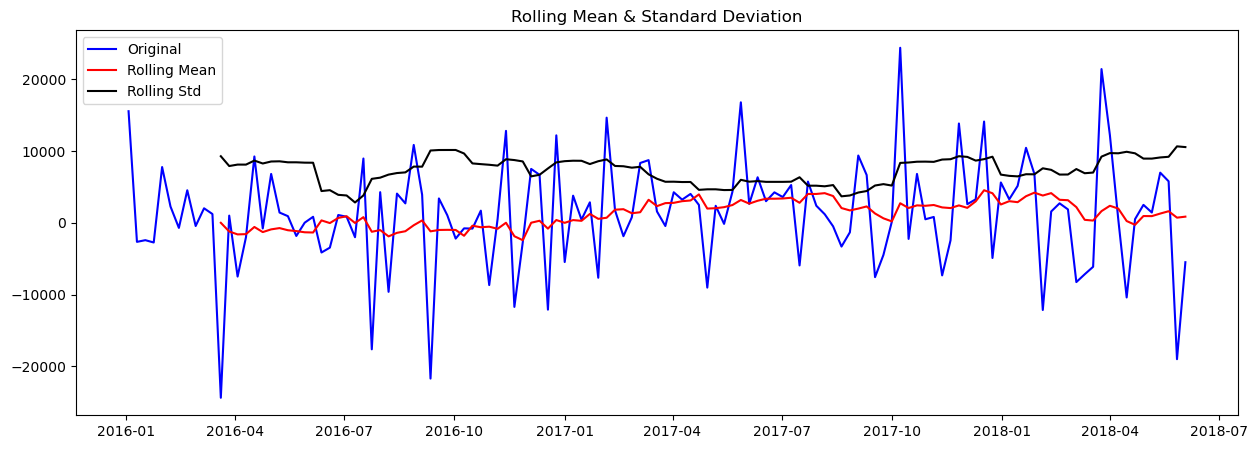

Results of Dickey-Fuller Test:
Test Statistic                 -8.85
p-value                         0.00
#Lags Used                      1.00
Number of Observations Used   125.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [36]:
test_stationarity(sales_train['Sales'].diff(52).dropna())

- Critival Value (5%) : -2.88 > Test Statistic : -8.85
- p-value : 0.00 > 0.05

Berdasarkan hail dari Dickey-Fuller Test, null hipotesis ditolak, sehingga dapat dikatakan Sales time series bersifat stasioner.

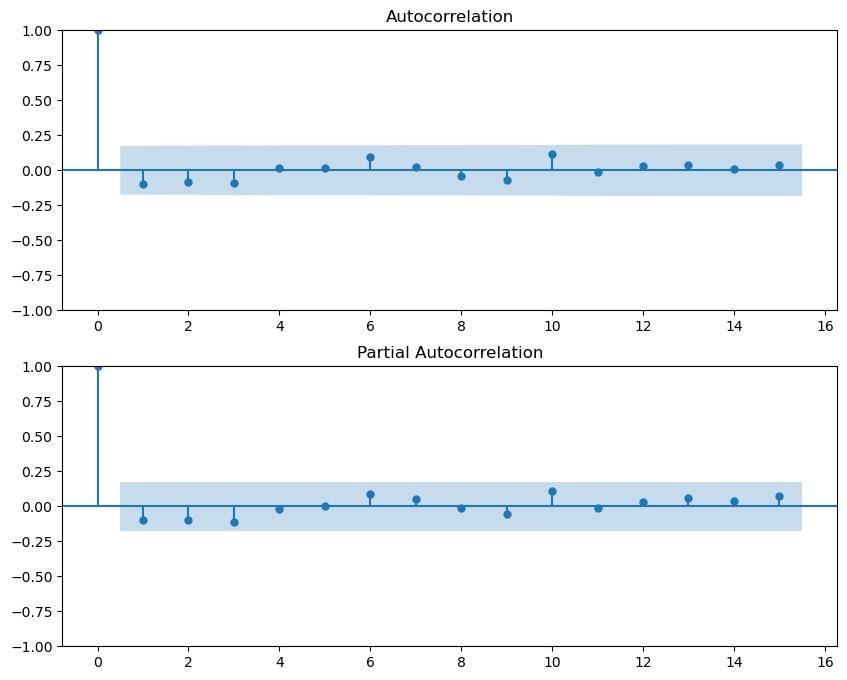

In [37]:
fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sales_train["Sales"].diff(52).dropna(), lags=15, ax=ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sales_train["Sales"].diff(52).dropna(), lags=15, ax=ax2)

Untuk model SARIMA, nilai p,d,q akan sama dengan dengan model ARIMA.
- P : 0
- D : 1
- Q : 0
- M : 52

In [38]:
sarima_model = ARIMA(sales_train['Sales'],
                    order = (1,0,2),
                    seasonal_order = (0,1,0,52)).fit()

print(sarima_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Sales   No. Observations:                  179
Model:             ARIMA(1, 0, 2)x(0, 1, [], 52)   Log Likelihood               -1314.982
Date:                           Thu, 04 Jan 2024   AIC                           2637.964
Time:                                   11:21:00   BIC                           2649.341
Sample:                               01-04-2015   HQIC                          2642.586
                                    - 06-03-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1852      6.824      0.027      0.978     -13.189      13.560
ma.L1         -0.2343      6.826     -0.034

### Fitted Values

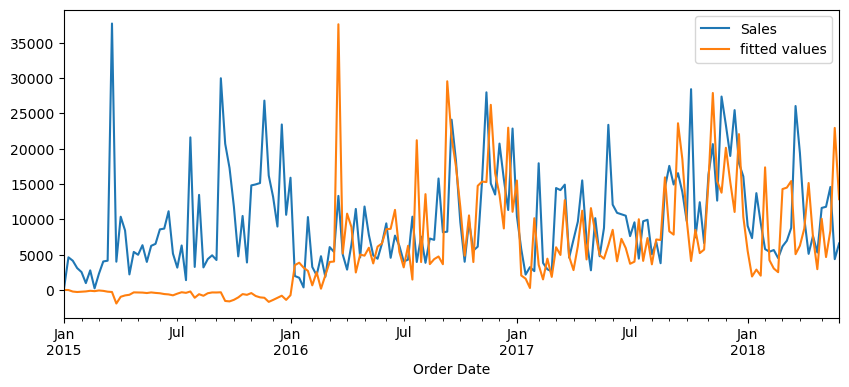

In [39]:
sales_train['Sales'].plot(figsize = (10,4), legend = True)

sarima_model.fittedvalues.plot(figsize = (10,4), label = "fitted values", legend = True)
plt.show()

### Forecasting

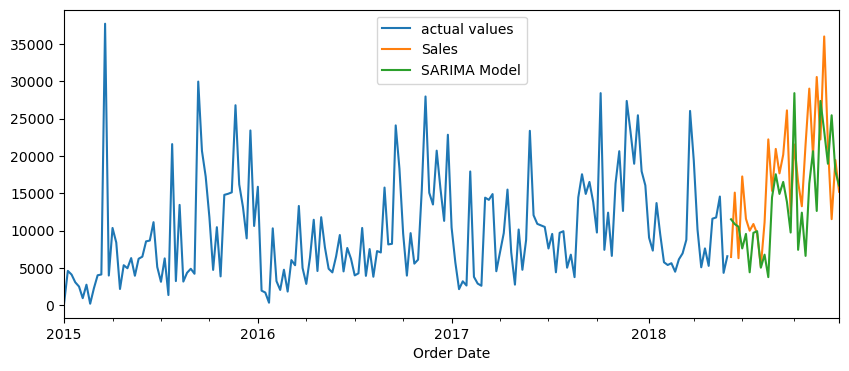

In [40]:
# Plot actual values of train and test data
sales_train['Sales'].plot(figsize = (10,4), legend = True, label = "actual values")
sales_test['Sales'].plot(figsize = (10,4), legend = True)

# Plot forecast results
sarima_model.forecast(steps = 30).plot(label = "SARIMA Model", legend = True)

plt.show()

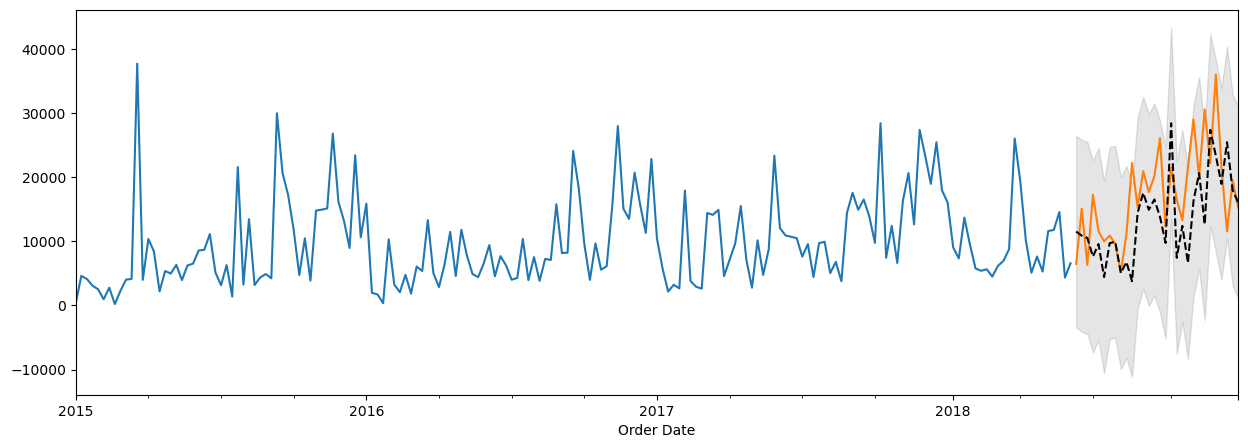

In [41]:
# Construct the forecasts and the prediction interval
fig, ax = plt.subplots(figsize = (15,5))

# Plot the data
sales_train['Sales'].plot(ax =ax)
sales_test['Sales'].plot(ax = ax)

# Plot the forecast
fcast = sarima_model.get_forecast(steps = 30).summary_frame()
fcast['mean'].plot(ax = ax, style='k--')

# Plot the conf interval
ax.fill_between(fcast.index,
               fcast['mean_ci_lower'],
               fcast['mean_ci_upper'], color='k', alpha=0.1)

plt.show()

### Evaluation

Calculate rmse in train data

In [42]:
rmse_train = np.sqrt(mse(sales_train['Sales'], sarima_model.fittedvalues))
rmse_train

9318.97072916545

In [43]:
sarima_rmse_test = np.sqrt(mse(sales_test['Sales'], sarima_model.forecast(steps = 30)))
sarima_rmse_test

8092.908741681263

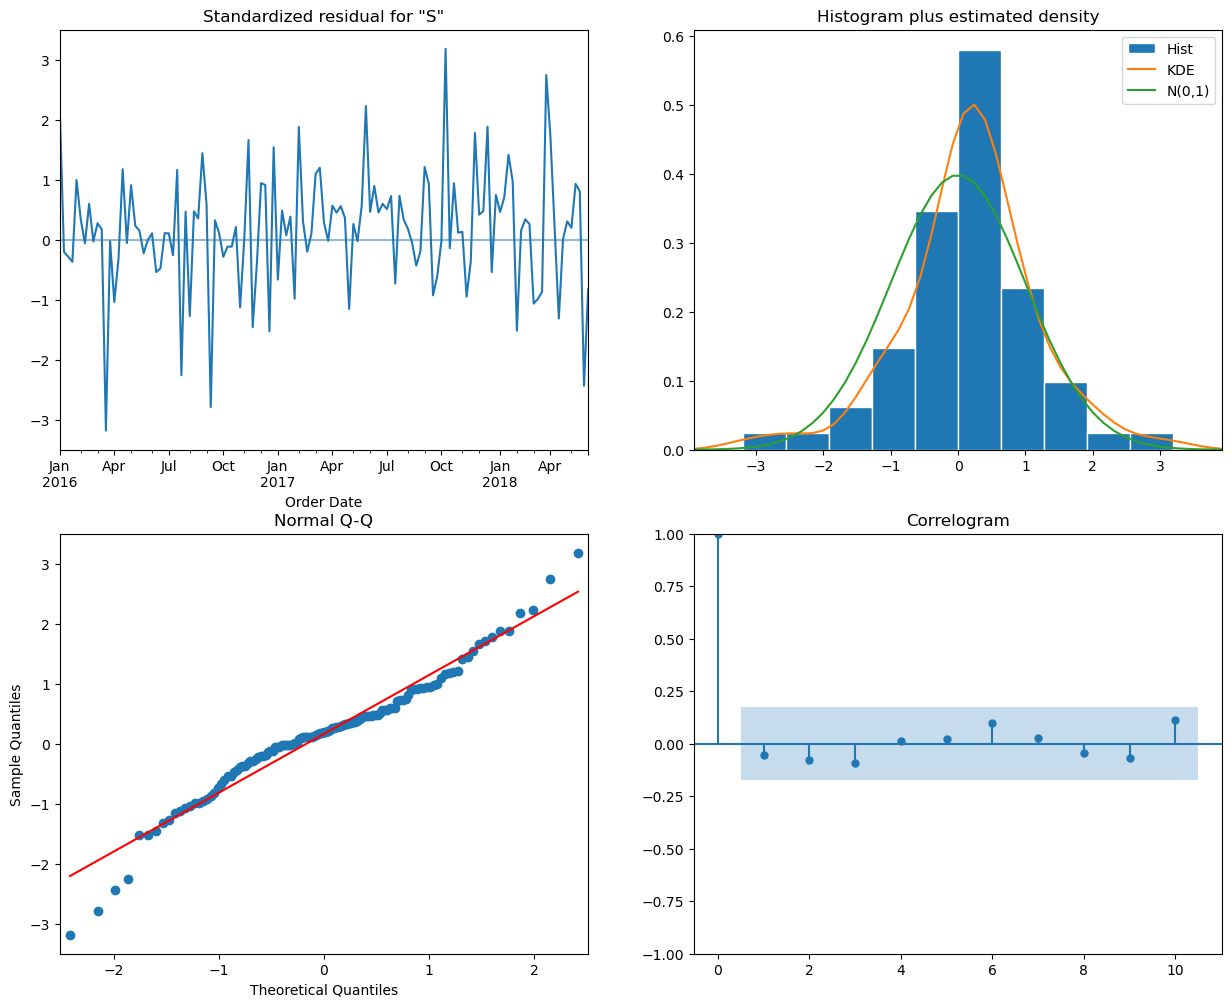

In [44]:
sarima_model.plot_diagnostics(figsize=(15,12))
plt.show()

## Order Selection in SARIMA Model

Define the orders

In [45]:
# Set the p, and q parameters to take any value between 0 and 3
p = q = range(0, 3)

# Set d = 0, remember it's not suggested to select d by model selection
d = [0]

In [46]:
# Generate all different combinations of p, q, and q triplets
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2)]

In [47]:
# Generate combinations of seasonal p, and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]
seasonal_pdq

[(0, 0, 0, 52),
 (0, 0, 1, 52),
 (0, 0, 2, 52),
 (1, 0, 0, 52),
 (1, 0, 1, 52),
 (1, 0, 2, 52),
 (2, 0, 0, 52),
 (2, 0, 1, 52),
 (2, 0, 2, 52)]

In [48]:
print('Examples of orders combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of orders combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 52)
SARIMAX: (0, 0, 1) x (0, 0, 2, 52)
SARIMAX: (0, 0, 2) x (1, 0, 0, 52)
SARIMAX: (0, 0, 2) x (1, 0, 1, 52)


In [49]:
aic = []
pdq_list = []
pdq_seasonal_list = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        sarima_model = ARIMA(sales_train["Sales"],
                             order=param,
                             seasonal_order=param_seasonal,
                             enforce_stationarity=False,
                             enforce_invertibility=False)
        
        results = sarima_model.fit()
        
        pdq_list.append(param)
        pdq_seasonal_list.append(param_seasonal)
        aic.append(results.aic)
        
        print("ARIMA{}{}12 - AIC:{}".format(param, param_seasonal, results.aic))

ARIMA(0, 0, 0)(0, 0, 0, 52)12 - AIC:3652.3263846518003
ARIMA(0, 0, 0)(0, 0, 1, 52)12 - AIC:4578.099286269964


C:\Users\pradi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



ARIMA(0, 0, 0)(0, 0, 2, 52)12 - AIC:1510.130151049779
ARIMA(0, 0, 0)(1, 0, 0, 52)12 - AIC:2574.074640928745
ARIMA(0, 0, 0)(1, 0, 1, 52)12 - AIC:5124.43704364564


C:\Users\pradi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



ARIMA(0, 0, 0)(1, 0, 2, 52)12 - AIC:1511.937344725878
ARIMA(0, 0, 0)(2, 0, 0, 52)12 - AIC:1527.8278503779406
ARIMA(0, 0, 0)(2, 0, 1, 52)12 - AIC:3026.180167001388


C:\Users\pradi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



ARIMA(0, 0, 0)(2, 0, 2, 52)12 - AIC:1513.338182344052
ARIMA(0, 0, 1)(0, 0, 0, 52)12 - AIC:3619.6618593583353
ARIMA(0, 0, 1)(0, 0, 1, 52)12 - AIC:13232.021243643236


C:\Users\pradi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



ARIMA(0, 0, 1)(0, 0, 2, 52)12 - AIC:1487.925237302007
ARIMA(0, 0, 1)(1, 0, 0, 52)12 - AIC:2573.5086569454793
ARIMA(0, 0, 1)(1, 0, 1, 52)12 - AIC:13157.340886823014


C:\Users\pradi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



ARIMA(0, 0, 1)(1, 0, 2, 52)12 - AIC:1489.6509244250385
ARIMA(0, 0, 1)(2, 0, 0, 52)12 - AIC:1527.1607159267248
ARIMA(0, 0, 1)(2, 0, 1, 52)12 - AIC:2968.5345858035716


C:\Users\pradi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



ARIMA(0, 0, 1)(2, 0, 2, 52)12 - AIC:1491.3404073387053
ARIMA(0, 0, 2)(0, 0, 0, 52)12 - AIC:3591.8627490084127
ARIMA(0, 0, 2)(0, 0, 1, 52)12 - AIC:12634.971195121152


C:\Users\pradi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



ARIMA(0, 0, 2)(0, 0, 2, 52)12 - AIC:1467.4037089576818
ARIMA(0, 0, 2)(1, 0, 0, 52)12 - AIC:2571.439436374602
ARIMA(0, 0, 2)(1, 0, 1, 52)12 - AIC:12624.291796881282


C:\Users\pradi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



ARIMA(0, 0, 2)(1, 0, 2, 52)12 - AIC:1469.024421122858
ARIMA(0, 0, 2)(2, 0, 0, 52)12 - AIC:1526.7753584269692
ARIMA(0, 0, 2)(2, 0, 1, 52)12 - AIC:3139.3666355281775


C:\Users\pradi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



ARIMA(0, 0, 2)(2, 0, 2, 52)12 - AIC:1470.816820718535
ARIMA(1, 0, 0)(0, 0, 0, 52)12 - AIC:3632.8143063750904
ARIMA(1, 0, 0)(0, 0, 1, 52)12 - AIC:13287.452615464597


C:\Users\pradi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



ARIMA(1, 0, 0)(0, 0, 2, 52)12 - AIC:1505.5136778299186
ARIMA(1, 0, 0)(1, 0, 0, 52)12 - AIC:2548.7458850318126
ARIMA(1, 0, 0)(1, 0, 1, 52)12 - AIC:4067.3265943746137


C:\Users\pradi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



ARIMA(1, 0, 0)(1, 0, 2, 52)12 - AIC:1507.2560448950712
ARIMA(1, 0, 0)(2, 0, 0, 52)12 - AIC:1505.629599220115
ARIMA(1, 0, 0)(2, 0, 1, 52)12 - AIC:2753.858316482605


C:\Users\pradi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



ARIMA(1, 0, 0)(2, 0, 2, 52)12 - AIC:1508.917650596356
ARIMA(1, 0, 1)(0, 0, 0, 52)12 - AIC:3609.8818606149434
ARIMA(1, 0, 1)(0, 0, 1, 52)12 - AIC:12816.60923231944


C:\Users\pradi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



ARIMA(1, 0, 1)(0, 0, 2, 52)12 - AIC:1487.297139068683
ARIMA(1, 0, 1)(1, 0, 0, 52)12 - AIC:2549.275862478271
ARIMA(1, 0, 1)(1, 0, 1, 52)12 - AIC:12714.55469547693


C:\Users\pradi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



ARIMA(1, 0, 1)(1, 0, 2, 52)12 - AIC:1481.9444344063713
ARIMA(1, 0, 1)(2, 0, 0, 52)12 - AIC:1507.1246881675554
ARIMA(1, 0, 1)(2, 0, 1, 52)12 - AIC:3019.7934300872325


C:\Users\pradi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



ARIMA(1, 0, 1)(2, 0, 2, 52)12 - AIC:1483.506186120855
ARIMA(1, 0, 2)(0, 0, 0, 52)12 - AIC:3591.9534129537683
ARIMA(1, 0, 2)(0, 0, 1, 52)12 - AIC:12995.295451195105


C:\Users\pradi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



ARIMA(1, 0, 2)(0, 0, 2, 52)12 - AIC:1468.9165313747694
ARIMA(1, 0, 2)(1, 0, 0, 52)12 - AIC:2551.076908419733
ARIMA(1, 0, 2)(1, 0, 1, 52)12 - AIC:12364.738976336215


C:\Users\pradi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



ARIMA(1, 0, 2)(1, 0, 2, 52)12 - AIC:1463.9897794601648
ARIMA(1, 0, 2)(2, 0, 0, 52)12 - AIC:1509.0274452974556
ARIMA(1, 0, 2)(2, 0, 1, 52)12 - AIC:2811.177367968344


C:\Users\pradi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



ARIMA(1, 0, 2)(2, 0, 2, 52)12 - AIC:1465.534211996788
ARIMA(2, 0, 0)(0, 0, 0, 52)12 - AIC:3609.352150653126
ARIMA(2, 0, 0)(0, 0, 1, 52)12 - AIC:5088.283229523765


C:\Users\pradi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



ARIMA(2, 0, 0)(0, 0, 2, 52)12 - AIC:1506.839491970861
ARIMA(2, 0, 0)(1, 0, 0, 52)12 - AIC:2527.5496226178548
ARIMA(2, 0, 0)(1, 0, 1, 52)12 - AIC:12923.69599709104


C:\Users\pradi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



ARIMA(2, 0, 0)(1, 0, 2, 52)12 - AIC:1508.6870991123435
ARIMA(2, 0, 0)(2, 0, 0, 52)12 - AIC:1487.0699371626954
ARIMA(2, 0, 0)(2, 0, 1, 52)12 - AIC:3471.319744859851


C:\Users\pradi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



ARIMA(2, 0, 0)(2, 0, 2, 52)12 - AIC:1490.768341552841
ARIMA(2, 0, 1)(0, 0, 0, 52)12 - AIC:3611.354552021283
ARIMA(2, 0, 1)(0, 0, 1, 52)12 - AIC:12860.385991093706


C:\Users\pradi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



ARIMA(2, 0, 1)(0, 0, 2, 52)12 - AIC:1489.051665012575
ARIMA(2, 0, 1)(1, 0, 0, 52)12 - AIC:2528.7735073737676
ARIMA(2, 0, 1)(1, 0, 1, 52)12 - AIC:12819.911280933979


C:\Users\pradi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



ARIMA(2, 0, 1)(1, 0, 2, 52)12 - AIC:1489.2792989732645
ARIMA(2, 0, 1)(2, 0, 0, 52)12 - AIC:1489.118891726362
ARIMA(2, 0, 1)(2, 0, 1, 52)12 - AIC:2475.2915102533216


C:\Users\pradi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



ARIMA(2, 0, 1)(2, 0, 2, 52)12 - AIC:1492.68438586202
ARIMA(2, 0, 2)(0, 0, 0, 52)12 - AIC:3593.838415158136
ARIMA(2, 0, 2)(0, 0, 1, 52)12 - AIC:12403.458862497017


C:\Users\pradi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



ARIMA(2, 0, 2)(0, 0, 2, 52)12 - AIC:1470.0645745929664
ARIMA(2, 0, 2)(1, 0, 0, 52)12 - AIC:2530.9695734829797
ARIMA(2, 0, 2)(1, 0, 1, 52)12 - AIC:12714.573356041015


C:\Users\pradi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



ARIMA(2, 0, 2)(1, 0, 2, 52)12 - AIC:1464.0668696416537
ARIMA(2, 0, 2)(2, 0, 0, 52)12 - AIC:1490.7869626106274
ARIMA(2, 0, 2)(2, 0, 1, 52)12 - AIC:2772.2872385248997


C:\Users\pradi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



ARIMA(2, 0, 2)(2, 0, 2, 52)12 - AIC:1467.0196875143915


In [50]:
# Tabulate each method and its AIC score
aic_models = pd.DataFrame({"pdq": pdq_list,
                          "pdq_seasonal": pdq_seasonal_list,
                          "AIC": aic})

aic_models

pdq   pdq_seasonal      AIC
0   (0, 0, 0)  (0, 0, 0, 52)  3652.33
1   (0, 0, 0)  (0, 0, 1, 52)  4578.10
2   (0, 0, 0)  (0, 0, 2, 52)  1510.13
3   (0, 0, 0)  (1, 0, 0, 52)  2574.07
4   (0, 0, 0)  (1, 0, 1, 52)  5124.44
..        ...            ...      ...
76  (2, 0, 2)  (1, 0, 1, 52) 12714.57
77  (2, 0, 2)  (1, 0, 2, 52)  1464.07
78  (2, 0, 2)  (2, 0, 0, 52)  1490.79
79  (2, 0, 2)  (2, 0, 1, 52)  2772.29
80  (2, 0, 2)  (2, 0, 2, 52)  1467.02

[81 rows x 3 columns]

In [51]:
best_aic = aic_models.loc[aic_models["AIC"].argmin()]

best_aic

pdq                 (1, 0, 2)
pdq_seasonal    (1, 0, 2, 52)
AIC                   1463.99
Name: 50, dtype: object

In [52]:
sarima_model = ARIMA(sales_train["Sales"], 
                     order = best_aic["pdq"],
                     seasonal_order = best_aic["pdq_seasonal"],
                     enforce_stationarity=False,
                     enforce_invertibility=False).fit()

print(sarima_model.summary())

C:\Users\pradi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



                                    SARIMAX Results                                     
Dep. Variable:                            Sales   No. Observations:                  179
Model:             ARIMA(1, 0, 2)x(1, 0, 2, 52)   Log Likelihood                -723.995
Date:                          Thu, 04 Jan 2024   AIC                           1463.990
Time:                                  11:33:34   BIC                           1482.203
Sample:                              01-04-2015   HQIC                          1471.241
                                   - 06-03-2018                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9745.8553   2.07e+04      0.471      0.638   -3.08e+04    5.03e+04
ar.L1          0.9806      0.055     17.762      0.

## Forecasting with Best Model

In [53]:
best_sarima = sarima_model.forecast(steps = 30)
best_sarima

2018-06-10    9859.10
2018-06-17    9930.35
2018-06-24    9471.56
2018-07-01    9301.90
2018-07-08    9191.93
2018-07-15    9656.35
2018-07-22    9843.87
2018-07-29    9600.08
2018-08-05   10269.04
2018-08-12   10410.37
2018-08-19   11415.59
2018-08-26   12022.08
2018-09-02   12695.31
2018-09-09   14474.14
2018-09-16   15131.76
2018-09-23   15060.63
2018-09-30   14632.32
2018-10-07   12836.11
2018-10-14   14325.81
2018-10-21   13957.61
2018-10-28   15418.88
2018-11-04   16300.77
2018-11-11   17520.24
2018-11-18   18766.73
2018-11-25   18009.45
2018-12-02   18632.96
2018-12-09   18755.58
2018-12-16   18632.61
2018-12-23   19027.27
2018-12-30    9503.69
Freq: W-SUN, Name: predicted_mean, dtype: float64

RMSE of the forecast

In [55]:
best_rmse_test = np.sqrt(mse(sales_test['Sales'], sarima_model.forecast(steps = 30)))
best_rmse_test

6680.739655600359

In [57]:
# Construct the forecasts and the prediction interval
fig, ax = plt.subplots(figsize = (15,5))

# Plot the data
sales_train['Sales'].plot(ax =ax)
sales_test['Sales'].plot(ax = ax)

# Plot the forecast
fcast = sarima_model.get_forecast(steps = 30).summary_frame()
fcast['mean'].plot(ax = ax, style='k--')

# Plot the conf interval
ax.fill_between(fcast.index,
               fcast['mean_ci_lower'],
               fcast['mean_ci_upper'], color='k', alpha=0.1)

plt.show()

## Time Series Cross Validation For ARIMA

In [56]:
def cross_validate_arima(X, od_arima, seasonal_od_arima, n_fold = 5, test_size = None, gap = 0):
    """
    Function to evaluate RMSE by time series cross-validation.

    Parameters
    ----------
    X : {array-like} of shape (n_sample, n_predictors)
        The independent variable or predictors.

    od_arima : {array-like} 
        The order of arima (p, d, q)

    seasonal_od_arima : {array-like} 
        The seasonal order of arima (P, D, Q)
        
    n_fold : int
        Number of n_split for TimeSeriesSplit.
        
    test_sizes : int
        Number of test_sizes for TimeSeriesSplit.
        
    gap : int
        Number of gap for TimeSeriesSplit.

    Returns
    -------
    score : float
        The average RMSE score.
    """
    
    # Placeholder for index 
    train_ind_list = []
    valid_ind_list = []
    
    # Define TS Split
    tscv = TimeSeriesSplit(n_splits = n_fold, 
                           test_size = test_size, 
                           gap = gap)
    
    # Get train and valid test index
    for i, (train_index, val_index) in enumerate(tscv.split(X)):
        train_ind_list.append(train_index)
        valid_ind_list.append(val_index)
        
    # Define the number of train sets
    n_split = len(train_ind_list)

    # Initialize RMSE score list for each valid and train set
    score_list_valid = []
    score_list_train = []    
    pred_train = []    
    pred_valid = []    

    for i in range(n_split):
        
        # Extract data from index
        X_train = X.iloc[train_ind_list[i]]
        X_valid = X.iloc[valid_ind_list[i]]

        # Fitting model
        model_arima = ARIMA(X_train, 
                     order = od_arima,
                     seasonal_order = seasonal_od_arima,
                     enforce_stationarity = False,
                     enforce_invertibility = False).fit()

        # Get fitted values
        
        start_date = X_valid.index[0]
        end_date = X_valid.index[-1]
        
        X_pred_train = model_arima.fittedvalues
        X_pred_valid = model_arima.predict(start = start_date, 
                                           end = end_date)

        # Calculate RMSE
        rmse_train = np.sqrt(mean_squared_error(y_true = X_train, 
                                                y_pred = X_pred_train))
        
        rmse_valid = np.sqrt(mean_squared_error(y_true = X_valid, 
                                                y_pred = X_pred_valid))

        # Append RMSE score in list
        score_list_valid.append(rmse_valid)
        # append RMSE score in list
        score_list_train.append(rmse_train)
        
        
        # Append RMSE score in list
        pred_train.append(X_pred_train)
        # append RMSE score in list
        pred_valid.append(X_pred_valid)
        
        
    # Calculate CV Score
    score_list = pd.DataFrame({"RMSE_train": score_list_train,
                               "RMSE_valid": score_list_valid})
    score_valid = np.mean(score_list_valid)

    return (train_ind_list, 
            valid_ind_list, 
            pred_train,
            pred_valid,
            score_valid, 
            score_list)

### Configure CV using number of folds

In [58]:
# Check the CV function
train_ind_list, valid_ind_list, \
X_pred_train, X_pred_valid, \
validation_set_score, score_folds = cross_validate_arima(X = sales_train,
                                                        n_fold = 4,
                                                        test_size = 20,
                                                        od_arima = (1, 0, 2),
                                                        seasonal_od_arima = (1, 0, 2, 52))

C:\Users\pradi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\pradi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\pradi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\Users\pradi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



In [59]:
n_split = len(train_ind_list)
x_train_list = []
x_valid_list = []

for i in range(n_split):
    x_train_list.append(sales_train.iloc[train_ind_list[i]])
    x_valid_list.append(sales_train.iloc[valid_ind_list[i]])

In [60]:
# Check the first fold of training set
x_train_list[0].shape

(99, 1)

In [61]:
# Check the first fold of testing set
x_valid_list[0].shape

(20, 1)

In [62]:
fig, axes = plt.subplots(len(x_train_list),1,
                        figsize=(14, 15))

for i in range(n_split):
    x_train_list[i].plot(ax = axes[i], label = "train", legend = True)
    x_valid_list[i].plot(ax = axes[i], label = "valid", legend = True)
    X_pred_valid[i].plot(ax = axes[i], label = "prediction", legend = True)
    
    axes[i].set_title(f"Forecast Results in Fold {i+1}")
    
plt.tight_layout()
plt.show()

### Summarize Evaluation

In [63]:
fold_rsme = []
for i in range(1, len(x_valid_list)):
    fold_rsme.append(np.sqrt(mean_squared_error(x_valid_list[i], X_pred_valid[i])))

In [64]:
folds_rmse = pd.DataFrame({"Fold": [i+1 for i in range(len(fold_rsme))],
                           "RMSE": [fold_rsme[i] for i in range(len(fold_rsme))]})

In [65]:
summary_score = pd.DataFrame({"Evaluation": ["Cross Validation",
                                             "Train Test Split"],
                              "RMSE": [np.mean(fold_rsme),
                                       best_rmse_test]})

In [66]:
folds_rmse

Fold     RMSE
0     1  4763.48
1     2 10415.30
2     3  6560.07

In [67]:
summary_score

Evaluation    RMSE
0  Cross Validation 7246.28
1  Train Test Split 6680.74

## Prophet Model

In [68]:
df.head()

Sales
Order Date        
2015-01-04  304.51
2015-01-11 4619.11
2015-01-18 4130.53
2015-01-25 3092.54
2015-02-01 2527.91

### Split Data

In [69]:
test_size = 30

sales_train = df[:-test_size]
sales_test = df[-test_size:]

plt.title('Sales train and test sets', size = 20)

plt.plot(sales_train, label='Training set')
plt.plot(sales_test, label='Test set', color='orange')

plt.legend();

### Data Preparation for Prophet

Model Prophet menggunakan nama dengan ketentuan tertentu. Sehingga perlu melakukan rename pada data kolom sebelum dilakukan modeling

In [70]:
# Reset index
sales_train.reset_index(inplace = True)

In [71]:
#Rename the 'Order Date' column as 'ds' and the forecast variable 'Sales' as 'y'
sales_train = sales_train.rename(columns={"Order Date": "ds", "Sales": "y"})
sales_train.head()

ds       y
0 2015-01-04  304.51
1 2015-01-11 4619.11
2 2015-01-18 4130.53
3 2015-01-25 3092.54
4 2015-02-01 2527.91

### Modeling

In [72]:
#Create model object
m = Prophet()

#Fit model in data training
m.fit(sales_train)

11:36:50 - cmdstanpy - INFO - Chain [1] start processing
11:36:51 - cmdstanpy - INFO - Chain [1] done processing


### Forecast 

In [73]:
#Extract the datetime from the testing data
future = sales_test.reset_index()
future = future.drop('Sales', axis=1)
future = future.rename(columns={"Order Date": "ds"})
future.head()

ds
0 2018-06-10
1 2018-06-17
2 2018-06-24
3 2018-07-01
4 2018-07-08

Make prediction using the model

In [74]:
forecast = m.predict(future)
forecast.head()

ds    trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2018-06-10 12404.94     5658.63    18206.16     12404.94     12404.94   
1 2018-06-17 12430.95     4844.60    18032.19     12430.95     12430.95   
2 2018-06-24 12456.96     4706.53    16494.60     12456.96     12456.96   
3 2018-07-01 12482.96     2495.10    15207.98     12482.96     12482.96   
4 2018-07-08 12508.97     1721.65    14678.73     12508.97     12508.97   

   additive_terms  additive_terms_lower  additive_terms_upper   yearly  \
0         -376.57               -376.57               -376.57  -376.57   
1         -657.12               -657.12               -657.12  -657.12   
2        -1941.28              -1941.28              -1941.28 -1941.28   
3        -3549.63              -3549.63              -3549.63 -3549.63   
4        -4235.60              -4235.60              -4235.60 -4235.60   

   yearly_lower  yearly_upper  multiplicative_terms  \
0       -376.57       -376.57                  0.00   
1       -657.12       -657.12                  0.00   
2      -1941.28      -1941.28                  0.00   
3      -3549.63      -3549.63                  0.00   
4      -4235.60      -4235.60                  0.00   

   multiplicative_terms_lower  multiplicative_terms_upper     yhat  
0                        0.00                        0.00 12028.37  
1                        0.00                        0.00 11773.83  
2                        0.00                        0.00 10515.68  
3                        0.00                        0.00  8933.33  
4                        0.00                        0.00  8273.37

In [75]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds     yhat  yhat_lower  yhat_upper
25 2018-12-02 20517.78    14262.51    26578.91
26 2018-12-09 20025.29    13979.60    26183.70
27 2018-12-16 20717.31    14126.10    26960.13
28 2018-12-23 20254.26    14094.04    26880.73
29 2018-12-30 16798.37    10640.26    23314.12

### Plot the Forecast Result

In [76]:
#Plot the forecast
fig1 = m.plot(forecast)

#Plot the component of forecast
fig2 = m.plot_components(forecast)

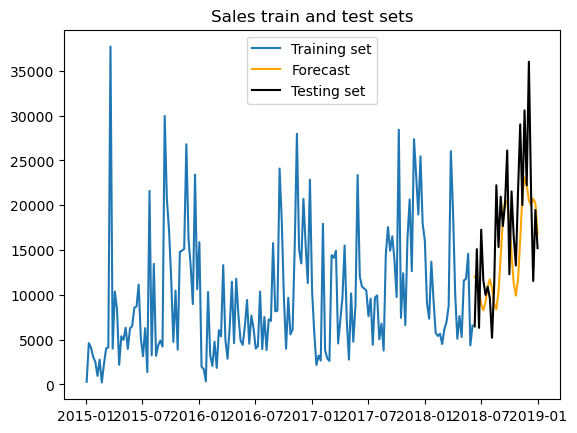

In [77]:
plt.title('Sales train and test sets')

plt.plot(sales_train.set_index("ds")["y"], label = 'Training set')
plt.plot(forecast.set_index("ds")["yhat"], label = 'Forecast', color = 'orange')
plt.plot(sales_test["Sales"], label = 'Testing set', color = 'k')
plt.legend();

### Evaluation

In [81]:
prophet_rmse_test = np.sqrt(mse(sales_test['Sales'], forecast['yhat']))
prophet_rmse_test

6425.88045235552

In [80]:
# Plot data train
sales_train.set_index("ds")["y"].plot(figsize = (10,4), legend = True, label='Training set')

# Plot forecast from prophet
forecast.set_index("ds")["yhat"].plot(figsize = (10,4), legend = True, label='Prophet')

# Plot forecast from ARIMA
arima_model.forecast(steps = 30).plot(label = "ARIMA Model", legend = True)

# Plot forecast from SARIMA
sarima_model.forecast(steps = 30).plot(label = "SARIMA Model", legend = True)

# Plot forecast from Order Selection SARIMA
best_sarima.plot(label = "Order Selection SARIMA Model", legend = True)

# Plot actual data
sales_test["Sales"].plot(label = "Testing set", legend = True, color = 'k')

plt.show()

In [83]:
summary_score = pd.DataFrame({"Evaluation": ["ARIMA",
                                             "SARIMA",
                                            "Best Model SARIMA",
                                            "Prophet"],
                              "RMSE": [arima_rmse_test,
                                       sarima_rmse_test,
                                      best_rmse_test,
                                      prophet_rmse_test]})

summary_score

Evaluation     RMSE
0              ARIMA 10419.70
1             SARIMA  8092.91
2  Best Model SARIMA  6680.74
3            Prophet  6425.88

## Conclusion

1. Time series forecasting merupakan tool yang sangat baik dalam memprediksi penjualan dan lainnya yang berubah seiring waktu.
2. Berdasarkan nilai RMSE nya model terbaik dalam analisa ini adalah **Prophet Model**.